In [ ]:
import os
import re
import gzip
import nibabel as nib

import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import CompositionalNets.Initialization_Code.config_initialization as comp_net_init_config
from CompositionalNets.Initialization_Code.comptSimMat import compute_similarity_matrix
import CompositionalNets.Code.config as comp_net_config
from CompositionalNets.Initialization_Code.vMF_clustering import learn_vmf_clusters, save_cluster_images
from CompositionalNets.Initialization_Code.Learn_mix_model_vMF_view import learn_mix_model_vMF

from src.config import directories
from src.models import UNet
from src.dataset import ClassificationDataset, apply_ct_abdomen_filter, NormalizeInstance, Resize

%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

In [29]:
vol_dir = os.path.join(directories['chaos_registrations'], 'affine', 'out')
regex = re.compile('.*\.nii\.gz')
largest_slices = []

for name in sorted(os.listdir(vol_dir)):
    
    if regex.match(name):
        
        fp = os.path.join(vol_dir, name)
        with gzip.open(fp, 'rb') as f:
            
            vol = nib.load(f.filename)
            vol_array = np.array(vol.dataobj, dtype=np.int16)
            
            num_slices = vol_array.shape[2]
            amount = np.zeros(num_slices)
            
            for i in range(num_slices):
                
                s = vol_array[...,i]
                background = s.min()
                amount[i] = np.sum(s==background)
            
#             idx = np.argmin(amount)
            idx = 60
            slices = [vol_array[...,i] for i in range(idx-5, idx+5)]
            for largest_slice in slices:
            
#             largest_slice = vol_array[...,np.argmin(amount)]
                largest_slice = apply_ct_abdomen_filter(largest_slice)
                largest_slice = np.rot90(largest_slice, k=1)
                largest_slice = np.stack((largest_slice, largest_slice, largest_slice), axis=2)

                # Normalize between 0 and 1
                largest_slice = (largest_slice - largest_slice.min()) / (largest_slice.max() - largest_slice.min())
                largest_slice = largest_slice.astype(np.float32)
                largest_slices.append(largest_slice)
            
largest_slices = np.asarray(largest_slices)
train_slices, test_slices = train_test_split(largest_slices, test_size=0.2, random_state=42)
# train_slices = largest_slices[:-3]
# test_slices = largest_slices[-3:]

dataset = ClassificationDataset(train_slices, [0] * len(train_slices), input_transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1)

/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: use the name attribute
  if sys.path[0] == '':


In [30]:
synthetic_images = []
# test_slices = largest_slices[div:].copy()

for i in range(0, len(test_slices)-2, 3):
    
    im = test_slices[i].copy()
    # im = im[110:390, 50:380]
    # im[150:200, 25:125] = im.min()
    im[200:300, 100:200] = im.min()
    synthetic_images.append(im)

    im = test_slices[i+1].copy()
    # im = im[115:370, 50:420]
    # im[50:100, 150:250] = im.min()
    im[200:300, 100:200] = im.min()
    synthetic_images.append(im)

    im = test_slices[i+2].copy()
    # im = im[115:385, 50:420]
    # im[120:190, 40:135] = im.min()
    im[150:200, 200:300] = im.min()
    synthetic_images.append(im)

im = np.tile(0.0, (512, 512, 3)).astype(np.float32)
synthetic_images.append(im)

# plt.imshow(im)

In [31]:
vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                     max_it=300, tol=5e-12,
                                     u_out_name='chaos_pool5_128_u_test_4.pickle',
#                                      u_out_name='chaos_pool5_512_u.pickle',
                                     p_out_name='chaos_pool5_128_p_test_4.pickle')
#                                      p_out_name='chaos_pool5_512_p.pickle')

In [37]:
save_cluster_images(vmf, loc_set, in_images=train_slices*255,
                    num_images=16, out_dir_name='test_4',
                    max_num_clusters=20)

Saving top 16 images for each cluster


In [ ]:
%%time
mat1, mat2 = compute_similarity_matrix(data_loader, 0, 'test_5',
                                       sim_dir_name='similarity_vgg_pool5_chaos_5',
                                       u_out_name='chaos_pool5_128_u_test_5.pickle',
                                       N_sub=20, num_layer_features=10)

Determine best threshold for binarization - 0 ...
Start compute sim matrix ... magicThresh 0.25
iter 1/16 1/16
comptSimMat iter time: 2.634808592001597
iter 1/16 2/16
comptSimMat iter time: 5.4479056676228845
iter 1/16 3/16
comptSimMat iter time: 5.577117598056793
iter 1/16 4/16
comptSimMat iter time: 5.4331968029340105
iter 1/16 5/16
comptSimMat iter time: 5.471607800324758
iter 1/16 6/16
comptSimMat iter time: 5.61115159591039
iter 1/16 7/16
comptSimMat iter time: 5.421767485141754
iter 1/16 8/16
comptSimMat iter time: 5.251371018091837
iter 1/16 9/16
comptSimMat iter time: 5.276008625825246
iter 1/16 10/16
comptSimMat iter time: 4.878195961316426
iter 1/16 11/16
comptSimMat iter time: 4.976171807448069
iter 1/16 12/16
comptSimMat iter time: 5.175570718447367
iter 1/16 13/16
comptSimMat iter time: 5.254148848851522
iter 1/16 14/16
comptSimMat iter time: 5.236472316582998
iter 1/16 15/16
comptSimMat iter time: 5.257177710533142
iter 1/16 16/16


In [61]:
learn_mix_model_vMF(data_loader, 0, sim_matrix_name='test_5',
                    num_layers=1, num_clusters_per_layer=1,
                    sim_dir_name='similarity_vgg_pool5_chaos_5',
                    dict_filename='chaos_pool5_128_u_test_5.pickle',
                    mixdir_name=f'mix_model_vmf_chaos_EM_all_test_5/',
                    im_channels=3)

FileNotFoundError: [Errno 2] No such file or directory: '/project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/models/init_vgg/similarity_vgg_pool5_chaos_5/test_5'

# Localize Occluders on Synthetic

In [ ]:
from torchvision import models
from PIL import Image
import cv2

from CompositionalNets.Code.config import categories, data_path, device_ids, categories_train, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from CompositionalNets.Code.config import config as cfg
from CompositionalNets.Code.model import Net
from CompositionalNets.Code.helpers import getVmfKernels, getCompositionModel, update_clutter_model
from CompositionalNets.Code.eval_occlusion_localization import visualize_response_map
from CompositionalNets.Code.losses import ClusterLoss
from CompositionalNets.Initialization_Code.config_initialization import extractor

In [ ]:
%%time
occ_likely = [0.6 for _ in range(len(categories_train))]

dict_dir = os.path.join(directories['CompositionalNets'],
                        'models/init_vgg/dictionary_vgg/chaos_pool5_128_u_test_5.pickle')
weights = getVmfKernels(dict_dir, device_ids)
mix_model_path = os.path.join(directories['CompositionalNets'], 
                             'models/init_vgg/mix_model_vmf_chaos_EM_all_test_5/')
mix_models = getCompositionModel(device_ids, mix_model_path, layer, 
                                 [0],
                                 compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)

model = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
            bool_mixture_bg=True,
            compnet_type=compnet_type, num_mixtures=num_mixtures, 
            vc_thresholds=cfg.MODEL.VC_THRESHOLD)
if device_ids:
    model.to(device_ids[0])

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
with torch.no_grad():
    for image in synthetic_images:
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
        
        image = image.unsqueeze(0)

        #localize occluder
#         if i == 2: pdb.set_trace() # there's an indexing issue if not using a mixture background
        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0)
        
        # concatenate original image and occluder map
#         img_orig = np.array(Image.fromarray(image_dataset[i], mode='F').convert('RGB'))
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
#         mask = np.array(Image.fromarray(mask.squeeze().numpy()*255//2, mode='F').convert('RGB'))
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
#         mask = cv2.resize(mask, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(canvas)
        plt.axis('off')
        fp = f'{directories["CompositionalNets"]}/results/lits/train_without_occluder/test_{i}.png'
        cv2.imwrite(fp, canvas)

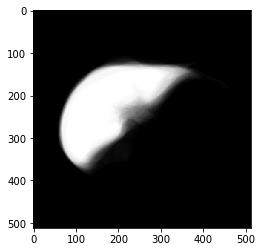

In [24]:
masks = []
for im in train_slices:
    im = im.copy()
    im[im != im.min()] = 1
    im[im == im.min()] = 0
    masks.append(im)
masks = np.asarray(masks)
average_train_slice = np.average(masks, axis=0)
plt.imshow(average_train_slice)